In [123]:
import tiktoken
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

# ----------------------------------------------------------

class DataLoaderLite:
	def __init__(self, B, T):
		self.B = B
		self.T = T

		# at init load tokens from disk and store them in memory
		with open('input.txt', 'r') as f:
			text = f.read()
		enc = tiktoken.get_encoding('gpt2')
		tokens = enc.encode(text)
		self.tokens = torch.tensor(tokens)
		print(f"loaded {len(self.tokens)} tokens")
		print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

		# state
		self.current_position = 0

	def next_batch(self):
		B, T = self.B, self.T
		buf = self.tokens[self.current_position:self.current_position + B * T + 1]
		x = (buf[:-1]).view(B, T) # inputs
		y = (buf[1:]).view(B, T) # targets

		self.current_position += B * T

		if self.current_position + (B * T + 1) > len(self.tokens):
			self.current_position = 0
		return x, y

class CausalSelfAttention(nn.Module):

	def __init__(self, config):
		super().__init__()
		assert config.n_embd % config.n_head == 0

		self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # key, query, value projections for all heads but in a batch. Saves you from three separate instantiations of nn.Linear
		self.c_proj = nn.Linear(config.n_embd, config.n_embd) # output projection
		self.c_proj.NANOGPT_SCALE_INIT = 1 # set flag so we know on initialization we need to scale down the std for these residual streams

		self.n_head = config.n_head
		self.n_embd = config.n_embd

		self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

	def forward(self, x, attention_mask=None):
	
		B, T, C = x.size() # batch size, sequence length, embedding dimension (n_embd)
	
		# Calculate query, key, value for all heads in batch, move head forward in the shape to be a batch dim alongside B
		# nh is "number of heads", hs is "head size", and C is number of channels (nh * hs)
		# e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs = 768 channels in the Transformer
	
		qkv = self.c_attn(x)
		q, k, v = qkv.split(self.n_embd, dim=2)
		k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
		q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
		v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
	
		# attention materializes the large (T, T) matrix for all queries and keys
		att = q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))) # --> (B, nh, T, T)
	
		# apply causal mask
		att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
	
		# apply padding mask if needed
		if attention_mask is not None:
			attention_mask = attention_mask[:, None, None, :] # (B, T) --> (B, 1, 1, T)
			att = att.masked_fill(attention_mask == 0, float('-inf'))
		
		att = F.softmax(att, dim=-1)
	
		y = att @ v # (B, nh, T, T) x (B, nh, T, hs) --> (B, nh, T, hs)
		y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
	
		# output project
		y = self.c_proj(y)
		return y


class MLP(nn.Module):

	def __init__(self, config):
		super().__init__()
		self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd) # On naming (eg 'c_fc'), we are replicating the GPT2 model
		self.gelu = nn.GELU(approximate='tanh')
		self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
		self.c_proj.NANOGPT_SCALE_INIT = 1 # set flag so we know on initialization we need to scale down the std for these residual streams

	def forward(self, x):
		x = self.c_fc(x)
		x = self.gelu(x)
		x = self.c_proj(x)
		return x


class Block(nn.Module):

	def __init__(self, config):
		super().__init__()
		self.ln_1 = nn.LayerNorm(config.n_embd)
		self.attn = CausalSelfAttention(config)
		self.ln_2 = nn.LayerNorm(config.n_embd)
		self.mlp = MLP(config)		

	def forward(self, x, attention_mask=None):
		x = x + self.attn(self.ln_1(x), attention_mask=attention_mask)
		x = x + self.mlp(self.ln_2(x)) 
		return x



@dataclass
class GPTConfig:
	block_size: int = 1024 # max sequence length
	vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
	n_layer: int = 12 # number of layers
	n_head: int = 12 # number of heads
	n_embd: int = 768 # embedding dimension

class GPT(nn.Module):
	
	def __init__(self, config):
		super().__init__()
		self.config = config

		self.transformer = nn.ModuleDict(dict(
			wte = nn.Embedding(config.vocab_size, config.n_embd),
			wpe = nn.Embedding(config.block_size, config.n_embd),
			h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
			ln_f = nn.LayerNorm(config.n_embd)
		))
		self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

		# weight sharing scheme
		self.transformer.wte.weight = self.lm_head.weight

		self.apply(self._init_weights)

	def _init_weights(self, module):
		if isinstance(module, nn.Linear):
			std = 0.02
			if hasattr(module, 'NANOGPT_SCALE_INIT'):
				std *= (2 * self.config.n_layer) ** -0.5 # Scale down the residual streams so std doesn't bloat as the streams add. Note we multiply by 2 bc it happens twice in each Block (one residual in attention, one in MLP)
			torch.nn.init.normal_(module.weight, mean=0.0, std=std)
			if module.bias is not None:
				torch.nn.init.zeros_(module.bias)
		elif isinstance(module, nn.Embedding):
			torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

	def resize_token_embeddings_and_tie_weights(self, new_vocab_size):
	
		old_weight = self.transformer.wte.weight.data
		old_vocab_size, n_embd = old_weight.shape # Get current size

		assert new_vocab_size > old_vocab_size, f"New vocab size is not larger than current vocab size"
		
		# Create new embedding layer and copy weights
		self.transformer.wte = nn.Embedding(new_vocab_size, n_embd)
		self.transformer.wte.weight.data[:old_vocab_size] = old_weight
		# nn.init.normal_(self.transformer.wte.weight.data[old_vocab_size:], mean=0.0, std=0.02)
		
		# Comment this out to illustrate bad initialization
		with torch.no_grad():
			average = self.transformer.wte.weight[:old_vocab_size].mean(dim=0)
			self.transformer.wte.weight.data[old_vocab_size:] = average
		
		# Create new lm_head layer
		self.lm_head = nn.Linear(n_embd, new_vocab_size, bias=False)
		
		# Tie weights
		self.lm_head.weight = self.transformer.wte.weight

		print(f"Model resized {model.transformer.wte} and {model.lm_head} layers to {new_vocab_size}")

	def forward(self, idx, targets=None, attention_mask=None):
		# idx is shape (B, T)
		B, T = idx.size()
		assert T <= self.config.block_size, f"Cannot forward sequence of length {T}. Block size is only {self.config.block_size}"
		
		# forward the token and position embeddings
		pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
		pos_emb = self.transformer.wpe(pos) # shape (T, n_embd)
		tok_emb = self.transformer.wte(idx) # shape (B, T, n_embd)
		x = tok_emb + pos_emb
		
		# forward through the blocks of the transformer
		for block in self.transformer.h:
			x = block(x, attention_mask=attention_mask)
		
		# forward the final layernorm and the classifier
		x = self.transformer.ln_f(x)
		logits = self.lm_head(x) # (B, T, vocab_size)

		loss = None
		if targets is not None:
			loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
		return logits, loss


	@classmethod
	def from_pretrained(cls, model_type):
		"""Loads pretrained GPT-2 model weights from huggingface"""
		assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
		from transformers import GPT2LMHeadModel
		print("loading weights from pretrained gpt: %s" % model_type)

		# n_layer, n_head and n_embd are determined from model_type
		config_args = {
			'gpt2':			dict(n_layer=12, n_head=12, n_embd=768), 	# 124M params
			'gpt2-medium':	dict(n_layer=24, n_head=16, n_embd=1024), 	# 350M params
			'gpt2-large':	dict(n_layer=36, n_head=20, n_embd=1280), 	# 774M param
			'gpt2-xl':		dict(n_layer=48, n_head=25, n_embd=1600), 	# 1558M params
		}[model_type]
		config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
		config_args['block_size'] = 1024  # always 1024 for GPT model checkpoints

		# create a from-scratch initialized minGPT model
		config = GPTConfig(**config_args)
		model = GPT(config)
		sd = model.state_dict()
		sd_keys = sd.keys()
		sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # dicard the mask / buffer

		# init a huggingface/transformers model
		model_hf = GPT2LMHeadModel.from_pretrained(model_type)
		sd_hf = model_hf.state_dict()

		# copy while ensuring all of the parameters are aligned and match in names and shapes
		sd_keys_hf = sd_hf.keys()
		sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # dicard the mask / buffer
		sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # dicard the mask / buffer
		transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
		# basically the openai checkppoints use a "Conv1D" module, but we only want to use a vanilla Linear
		# this means we have to transpose these weights when we import them
		assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
		for k in sd_keys_hf:
			if any(k.endswith(w) for w in transposed):
				# special treatment for the Conv1D weights we need to transpose
				assert sd_hf[k].shape[::-1] == sd[k].shape
				with torch.no_grad():
					sd[k].copy_(sd_hf[k].t())
			else:
				assert sd_hf[k].shape == sd[k].shape
				with torch.no_grad():
					sd[k].copy_(sd_hf[k])

		return model

	def generate(self, device, max_length=50, num_return_sequences=1, query="Best tacos?", tokenizer=None):

		if tokenizer is None:
			from transformers import GPT2Tokenizer
			tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
		
		tokens = tokenizer.encode(query)
		tokens = torch.tensor(tokens, dtype=torch.long)
		tokens = tokens.unsqueeze(0)
		tokens = tokens.repeat(num_return_sequences,1)
		x = tokens
		x = x.to(device)
		
		while x.size(1) < max_length:
			with torch.no_grad():
				logits, loss = self(x)
				logits = logits[:, -1, :]
				probs = F.softmax(logits, dim=-1)
				topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
				ix = torch.multinomial(topk_probs, 1)
				xcol = torch.gather(topk_indices, -1, ix)
				x = torch.cat((x, xcol), dim=1)
		
				for i in range(num_return_sequences):
					tokens = x[i, :].tolist()
					decoded = tokenizer.decode(tokens)
					print(decoded)

In [119]:
import json
import random
from transformers import GPT2Tokenizer

class QADataLoader:
    def __init__(self, filepath, max_length=512, shuffle=True):
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.max_length = max_length
        self.shuffle = shuffle

        self.tokenizer.add_special_tokens({
            "bos_token": "<BOS>",
            "eos_token": "<EOS>",
            "sep_token": "<SEP>",
            "pad_token": "<PAD>"
        })

        self.special_tokens = {
            "<BOS>": self.tokenizer.encode("<BOS>")[0],
            "<SEP>": self.tokenizer.encode("<SEP>")[0],
            "<EOS>": self.tokenizer.encode("<EOS>")[0],
            "<PAD>": self.tokenizer.encode("<PAD>")[0]
        }

        self.samples = []
        with open(filepath, 'r') as f:
            for line in f:
                item = json.loads(line.strip())
                q, a = item["prompt"], item["completion"]
                tokens = self.encode_sample(q, a)
                if len(tokens["input_ids"]) <= self.max_length:
                    self.samples.append(tokens)

    def encode_sample(self, question, answer):
        q_tokens = self.tokenizer.encode(question)
        a_tokens = self.tokenizer.encode(answer)

        input_ids = (
            [self.special_tokens["<BOS>"]] + 
            q_tokens + 
            [self.special_tokens["<SEP>"]] +
            a_tokens +
            [self.special_tokens["<EOS>"]]
        )

        label_ids = (
            [-100] * (1 + len(q_tokens) + 1) + 
            a_tokens +
            [self.special_tokens["<EOS>"]]
         )

        return {"input_ids": input_ids, "label_ids": label_ids}     


    def __len__(self):
        return len(self.samples)

    def get_tokenizer(self):
        return self.tokenizer

    def get_batch(self, batch_size):
        if self.shuffle:
            batch = random.sample(self.samples, batch_size)
        else:
            batch = self.samples[:batch_size]
        
        max_len = max(len(sample["input_ids"]) for sample in batch)
        input_ids_batch = []
        label_ids_batch = []
        attention_mask_batch = []

        for sample in batch:
            pad_len = max_len - len(sample["input_ids"])
            input_ids = sample["input_ids"] + [self.special_tokens["<PAD>"]] * pad_len
            label_ids = sample["label_ids"] + [-100] * pad_len
            attention_mask = [1] * len(sample["input_ids"]) + [0] * pad_len

            input_ids_batch.append(input_ids)
            label_ids_batch.append(label_ids)
            attention_mask_batch.append(attention_mask)
            
        input_ids_batch = torch.tensor(input_ids_batch)
        label_ids_batch = torch.tensor(label_ids_batch)
        attention_mask_batch = torch.tensor(attention_mask_batch)

        return input_ids_batch, label_ids_batch, attention_mask_batch

In [ ]:
max_length = 40
num_return_sequences = 3

tokens = tokenizer.encode("Should I take a job at Google?")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0)
tokens = tokens.repeat(num_return_sequences,1)
x = tokens

while x.size(1) < max_length:
    with torch.no_grad():
        logits, loss = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)

        for i in range(num_return_sequences):
            tokens = x[i, :].tolist()
            decoded = tokenizer.decode(tokens)
            print(decoded)

In [ ]:
# SCRATCH - DELETE LATER. run it single time and watch results

# model.generate(max_length=20, num_return_sequences=1, query="Should I take the job at Google?")

model = GPT(GPTConfig)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Confirm gibberish
model.generate(max_length=15)

# Load GPT2 weights
model = model.from_pretrained('gpt2-medium')

# Confirm coherency
model.generate(max_length=15)

print("Embedding for '!'", model.transformer.wte.weight.data[50256])

# Load dataset, update vocab with new special tokens
dataloader = QADataLoader("qa_small_dataset.jsonl", max_length=512)
tokenizer = dataloader.get_tokenizer()
new_length = len(tokenizer.get_vocab())
print("Before resizing...", model.transformer.wte.weight.shape)
model.resize_token_embeddings_and_tie_weights(new_length)

print("Embedding for '!'", model.transformer.wte.weight.data[50256])
print("Embedding for '!'", model.transformer.wte.weight.data[50257:])

model.generate(max_length=15, tokenizer=tokenizer)


# from torch.optim import AdamW


# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [ ]:
device = "cpu"
if torch.cuda.is_available():
	device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
	device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)
if torch.cuda.is_available():
	torch.cuda.manual_seed(1337)


model = GPT(GPTConfig)

model = model.from_pretrained('gpt2-medium')

dataloader = QADataLoader("qa_dataset.jsonl", max_length=512)
tokenizer = dataloader.get_tokenizer()
new_length = len(tokenizer.get_vocab())
print("Before resizing...", model.transformer.wte.weight.shape)
model.resize_token_embeddings_and_tie_weights(new_length)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for i in range(50):
    x, y, att_mask = dataloader.get_batch(4)
    x, y, att_mask = x.to(device), y.to(device), att_mask.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y, att_mask)
    loss.backward()
    optimizer.step()
    print(f"step {i}, loss: {loss.item()}")

In [124]:
model = GPT(GPTConfig())

model = model.from_pretrained('gpt2-medium')

dataloader = QADataLoader("qa_dataset.jsonl", max_length=512)
tokenizer = dataloader.get_tokenizer()
new_length = len(tokenizer.get_vocab())
# print("Before resizing...", model.transformer.wte.weight.shape)
model.resize_token_embeddings_and_tie_weights(new_length)

loading weights from pretrained gpt: gpt2-medium


Token indices sequence length is longer than the specified maximum sequence length for this model (25603 > 1024). Running this sequence through the model will result in indexing errors


Model resized Embedding(50261, 1024) and Linear(in_features=1024, out_features=50261, bias=False) layers to 50261


In [ ]:
# PLOT THE SPECIAL TOKENS TO SEE HOW OFF IT IS

model.lm_head.weight.data[-4:] = model.lm_head.weight.data[tokenizer.encode('.')[0]]

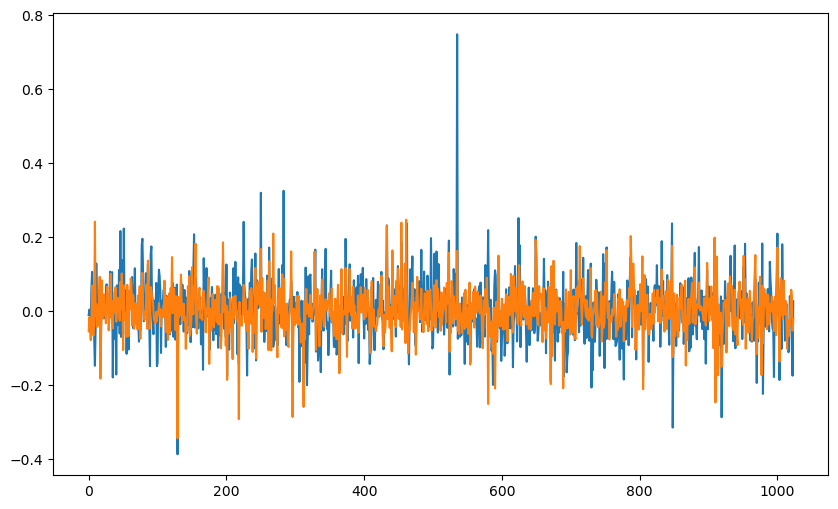

In [125]:
# import matplotlib.pyplot as plt
# import numpy as np

weights0 = model.lm_head.weight.data[0]
weights1 = model.lm_head.weight.data[-4]

weights0 = model.lm_head.weight.data[0]
weights1 = model.lm_head.weight.data[-4]

plt.figure(figsize=(10,6))
plt.plot(range(len(weights0)), weights0)
plt.plot(range(len(weights1)), weights1)
plt.show()

# model.lm_head.weight[-1].norm()

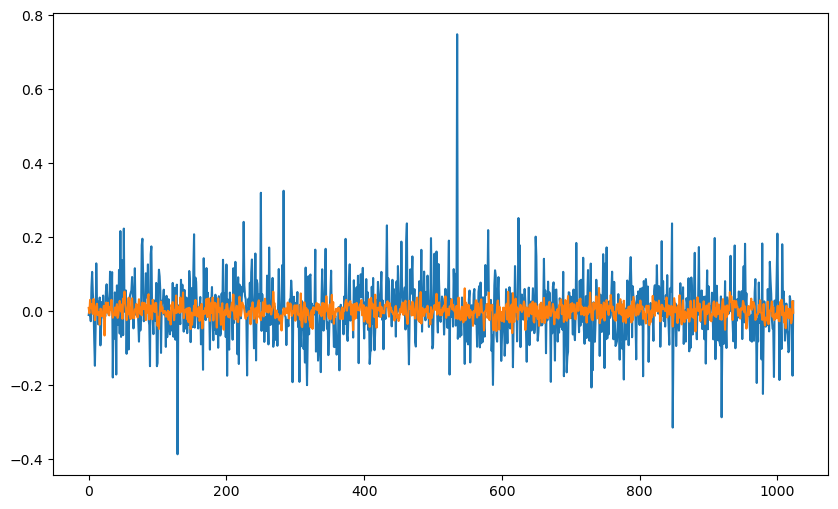

In [107]:
# import matplotlib.pyplot as plt
# import numpy as np

weights0 = model.lm_head.weight.data[0]
weights1 = model.lm_head.weight.data[-4]

plt.figure(figsize=(10,6))
plt.plot(range(len(weights0)), weights0)
plt.plot(range(len(weights1)), weights1)
plt.show()

# model.lm_head.weight[-1].norm()

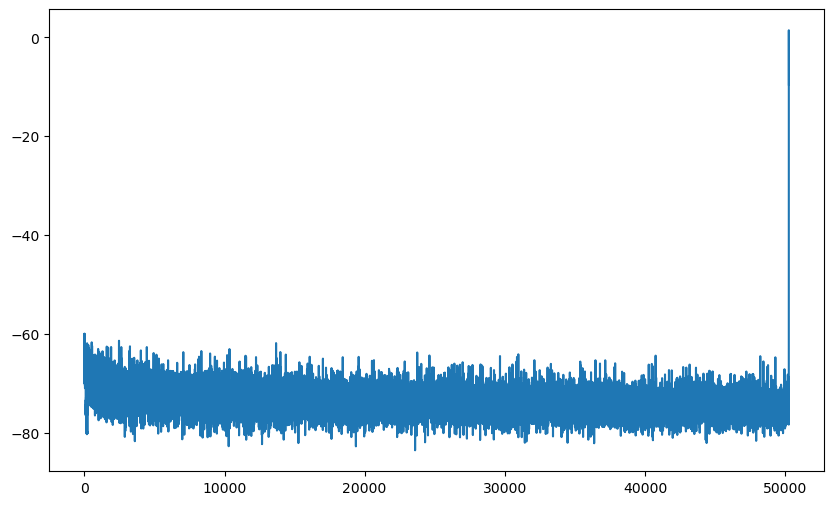

In [110]:
x = tokenizer.encode("Hello world")
x = torch.tensor(x)
x = x.unsqueeze(0)

logits, _ = model(x)

gooz = logits[:, -1, :]
gooz = gooz.squeeze(0).data
gooz

plt.figure(figsize=(10,6))
plt.plot(range(len(gooz)), gooz)
plt.show()

In [111]:
probs = F.softmax(gooz, dim=-1)
torch.topk(probs, 10, dim=-1)

torch.return_types.topk(
values=tensor([5.1415e-01, 2.7100e-01, 2.1484e-01, 8.6341e-06, 1.1272e-27, 9.8407e-28,
        6.5170e-28, 6.3343e-28, 5.1242e-28, 2.6649e-28]),
indices=tensor([50257, 50259, 50258, 50260,    11,     0,     1,    13,     6,  2474]))

In [122]:
model.generate(max_length=14, device='cpu', tokenizer=tokenizer)

Best tacos?

Best tacos?


Best tacos?

"
Best tacos?

"What
Best tacos?

"What's
Best tacos?

"What's a
Best tacos?

"What's a Taco
Best tacos?

"What's a Taco Bowl
Best tacos?

"What's a Taco Bowl for
Best tacos?

"What's a Taco Bowl for ya
Best tacos?

"What's a Taco Bowl for ya?"


In [114]:
print(model.lm_head.weight.data[-4:])
average = model.lm_head.weight[:-4].mean(dim=0)
# model.lm_head.weight[-1].norm()
model.lm_head.weight.data[-4:] = average
print(model.lm_head.weight.data[-4:])

tensor([[ 0.0077, -0.0068,  0.0294,  ..., -0.0237,  0.0263, -0.0053],
        [ 0.0013,  0.0305,  0.0396,  ...,  0.0457, -0.0456, -0.0249],
        [-0.0029, -0.0075,  0.0028,  ..., -0.0079, -0.0072,  0.0075],
        [-0.0377, -0.0185, -0.0242,  ...,  0.0059, -0.0048, -0.0023]])
tensor([[-0.0558, -0.0170, -0.0460,  ...,  0.0417, -0.0542, -0.0225],
        [-0.0558, -0.0170, -0.0460,  ...,  0.0417, -0.0542, -0.0225],
        [-0.0558, -0.0170, -0.0460,  ...,  0.0417, -0.0542, -0.0225],
        [-0.0558, -0.0170, -0.0460,  ...,  0.0417, -0.0542, -0.0225]])
